In [1]:
import numpy as np
import xarray as xr
import dask.array as da
from dask.distributed import Client, LocalCluster
import gc
from matplotlib import pyplot as plt

In [2]:
EARTH_RADIUS_KM = 6371.0
MAX_DIST_KM = 500
TIME_TOL_HOURS = 8
ALT_MIN, ALT_MAX = 0.5, 64.5
ALT_GRID = np.arange(ALT_MIN, ALT_MAX + 1, dtype=np.float32)
TIME_TOL = np.timedelta64(TIME_TOL_HOURS, 'h').astype('timedelta64[ns]')

CHUNK_SIZE_L = 50000
CHUNK_SIZE_S = 25000

In [3]:
def process_dataarray(da_o3):
    if da_o3.name != 'O3.MIXING.RATIO.VOLUME_ABSORPTION.SOLAR':
        da_transposed = da_o3.transpose('time', 'altitude')
        
        n_time = da_transposed.sizes['time']
        n_alt = da_transposed.sizes['altitude']
        
        time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
        alt_chunks = min(32, n_alt)
        
        if isinstance(da_transposed.data, da.Array):
            da_transposed = da_transposed.chunk({'time': time_chunks, 'altitude': alt_chunks})
        else:
            da_transposed.data = da.from_array(da_transposed.data, 
                                            chunks=(time_chunks, alt_chunks))
        
        return da_transposed
    else:
        n_time = da_o3.sizes['DATETIME']
        n_alt = da_o3.sizes['altitude1']

        time_chunks = CHUNK_SIZE_L if n_time > 500000 else CHUNK_SIZE_S
        alt_chunks = min(32, n_alt)
        
        if isinstance(da_o3.data, da.Array):
            da_o3 = da_o3.chunk({'DATETIME': time_chunks, 'altitude1': alt_chunks})
        else:
            da_o3.data = da.from_array(da_o3.data, 
                                            chunks=(time_chunks, alt_chunks))
        
        return da_o3

def compute_diffs(o3L, o3S):
    """Vectorized relative, absolute and raw difference computation"""
    sum_vals = o3L + o3S
    diff_vals = o3L - o3S
    return 200 * (diff_vals / sum_vals), diff_vals

def haversine_vectorized(lat1, lon1, lat2, lon2):
    """Vectorized Haversine distance calculation between points (in radians)"""
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return EARTH_RADIUS_KM * c

In [4]:
import sys
sys.path.extend([
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\ACEFTS",
    r"C:\Users\salla\Onedrive(uoft acc)\OneDrive - University of Toronto\Desktop\School Information\NSERC\NSERC\PEARL FTIR O3"
])

import ACEFTS_helper as ACE
import PEARL_FTIR_helper as PEARL

In [5]:
daA = ACE.get_vmr()
daP = PEARL.get_vmr()

In [6]:
daA = daA.sel(altitude=slice(ALT_MIN, ALT_MAX)).interp({"altitude": ALT_GRID})
daP = daP.sel(altitude1=slice(ALT_MIN, ALT_MAX)).interp({"altitude1": ALT_GRID})

daA = process_dataarray(daA)
daP = process_dataarray(daP)

In [7]:
cluster = LocalCluster(
    n_workers=2,
    threads_per_worker=2,
    memory_limit='3GB',
    processes=False,
    dashboard_address=None
)
client = Client(cluster)

In [8]:
o3A_arr = daA.values.astype(np.float32)
latA = daA.latitude.values
lonA = daA.longitude.values
tA = daA.time.values.astype('datetime64[ns]')

o3P_arr = daP.values.astype(np.float32)
tP = daP.DATETIME.values.astype('datetime64[ns]')
num_P_data = len(tP)
latP = np.array([PEARL.latitude] * num_P_data)
lonP = np.array([PEARL.longitude] * num_P_data)

tP_min = tP.min() - TIME_TOL
tP_max = tP.max() + TIME_TOL
time_mask = (tA >= tP_min) & (tA <= tP_max)
tA_filtered = tA[time_mask]
o3A_arr_filtered = o3A_arr[time_mask]
latA_filtered = latA[time_mask]
lonA_filtered = lonA[time_mask]

client.close()
cluster.close()
del o3A_arr, latA, lonA
gc.collect()

C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\distributed\client.py:3363: UserWarning: Sending large graph of size 65.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


3935

In [9]:
tA_ns = tA_filtered.astype(np.int64)
tP_ns = tP.astype(np.int64)
TIME_TOL_ns = TIME_TOL.astype(np.int64)

n_alt = len(ALT_GRID)
MAX_DIST_RAD = MAX_DIST_KM / EARTH_RADIUS_KM

processed_pairs = 0
o3P_coincidences = []
o3A_coincidences = []

time_bins = np.arange(tA_ns.min(), tA_ns.max() + 1, TIME_TOL_ns)
bin_indices = np.digitize(tA_ns, time_bins)

max_bin = len(time_bins) + 1
time_binned_arrays = [np.array([], dtype=np.int64) for _ in range(max_bin + 1)]

for bin_id in range(0, max_bin + 1):
    time_binned_arrays[bin_id] = np.where(bin_indices == bin_id)[0]

bin_offsets = np.arange(-1, 2)

for s_idx, (s_time, s_lat, s_lon) in enumerate(zip(tP_ns, latP, lonP)):
    if s_idx % 10000 == 0:
        print(f"Processing ACE-FTS point {s_idx}/{len(tP)}...")
    
    center_bin = np.digitize(s_time, time_bins)
    bin_ids = center_bin + bin_offsets
    bin_ids = bin_ids[(bin_ids >= 1) & (bin_ids < max_bin)]

    candidate_indices = np.concatenate([time_binned_arrays[bin_id] for bin_id in bin_ids])
    if candidate_indices.size == 0:
        continue

    time_diffs = np.abs(tA_ns[candidate_indices] - s_time)
    time_mask = time_diffs <= TIME_TOL_ns

    if not np.any(time_mask):
        continue

    time_valid_indices = candidate_indices[time_mask]
    candidate_lats = latA_filtered[time_valid_indices]
    candidate_lons = lonA_filtered[time_valid_indices]
    
    dists = haversine_vectorized(s_lat, s_lon, candidate_lats, candidate_lons)
    min_idx = np.argmin(dists)
    min_dist = dists[min_idx]

    if min_dist <= MAX_DIST_KM:
        best_L_idx = time_valid_indices[min_idx]
        o3A_coincidences.append(o3A_arr_filtered[best_L_idx])
        o3P_coincidences.append(o3P_arr[s_idx])
        processed_pairs += 1
        if processed_pairs % 1000 == 0:
            print(f"Found {processed_pairs} pairs at ACE point {s_idx}...")

o3P_coincidences = np.vstack(o3P_coincidences)
o3A_coincidences = np.vstack(o3A_coincidences)
print(f"Total coincidences found: {processed_pairs}")

Processing ACE-FTS point 0/6261...
Found 1000 pairs at ACE point 4183...
Total coincidences found: 1359


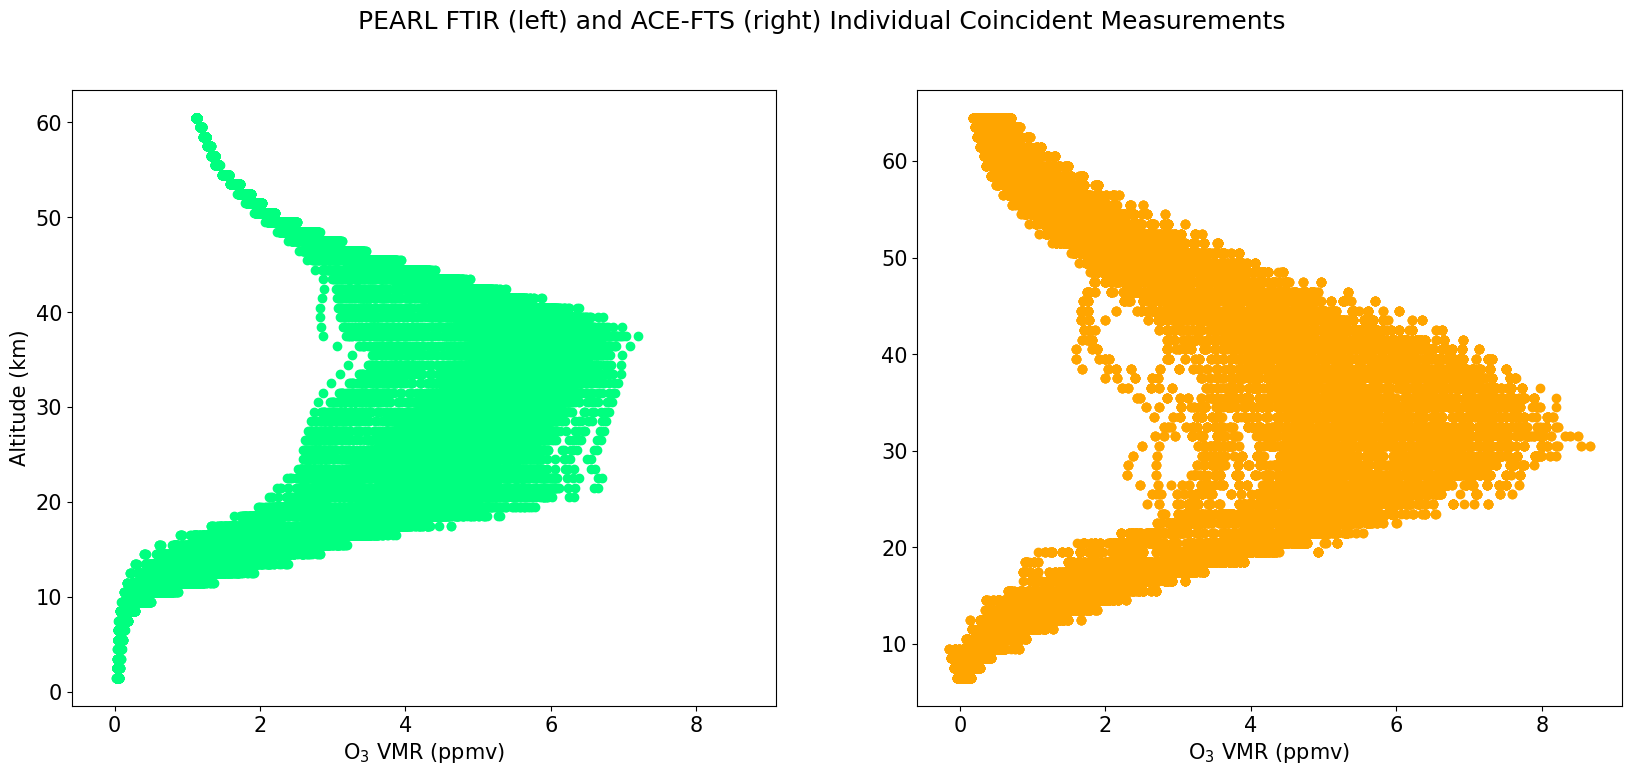

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (20,8))
for i, alt in enumerate(ALT_GRID):
    axes[0].scatter(o3P_coincidences[:,i] * 10**6, [alt] * o3P_coincidences.shape[0], color = "springgreen")

for i, alt in enumerate(ALT_GRID):
    axes[1].scatter(o3A_coincidences[:,i] * 10**6, [alt] * o3A_coincidences.shape[0], color = "orange")

axes[0].set_xlim(*axes[1].get_xlim())

axes[0].set_xlabel("O$_3$ VMR (ppmv)")
axes[1].set_xlabel("O$_3$ VMR (ppmv)")
axes[0].set_ylabel("Altitude (km)")

plt.suptitle("PEARL FTIR (left) and ACE-FTS (right) Individual Coincident Measurements" + " (All time)")

title = fig._suptitle.get_text()
fig.savefig(title, bbox_inches="tight")

In [11]:
rel, abs = compute_diffs(o3A_coincidences, o3P_coincidences)

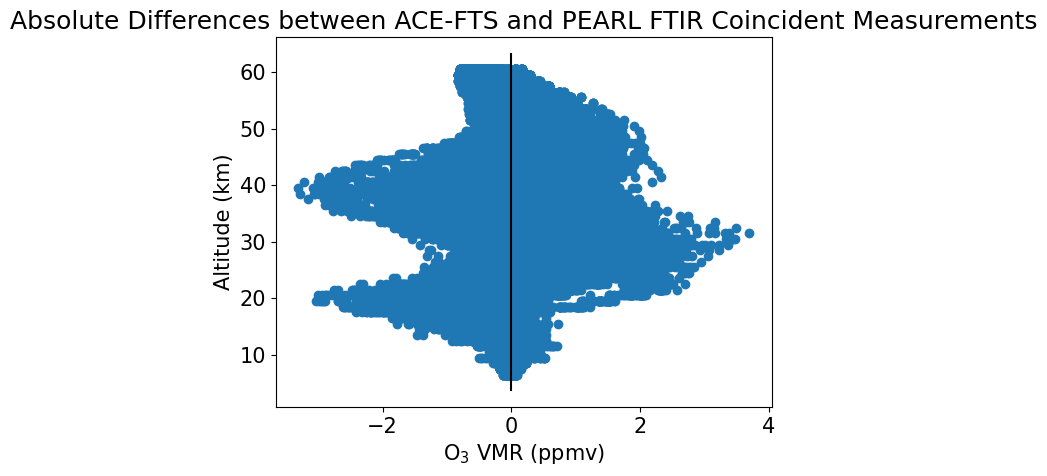

In [ ]:
for i, alt in enumerate(ALT_GRID):
    plt.scatter(abs[:,i] * 10**6, [alt] * abs.shape[0], color = "C0")

plt.plot([0, 0], list(plt.ylim()), color = "black")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between ACE-FTS and PEARL FTIR Coincident Measurements" + " (All time)")

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [13]:
rel_diffs = np.nanmean(rel, axis = 0)
rel_std = np.nanstd(rel, axis = 0)
rel_err = rel_std / (rel.shape[0] ** 0.5)

abs_diffs = np.nanmean(abs, axis = 0)
abs_std = np.nanstd(abs, axis = 0)
abs_err = np.nanstd(abs, axis = 0) / (abs.shape[0] ** 0.5)

C:\Users\salla\AppData\Local\Temp\ipykernel_17588\1016612721.py:1: RuntimeWarning: Mean of empty slice
  rel_diffs = np.nanmean(rel, axis = 0)
C:\Users\salla\AppData\Roaming\Python\Python312\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\salla\AppData\Local\Temp\ipykernel_17588\1016612721.py:5: RuntimeWarning: Mean of empty slice
  abs_diffs = np.nanmean(abs, axis = 0)


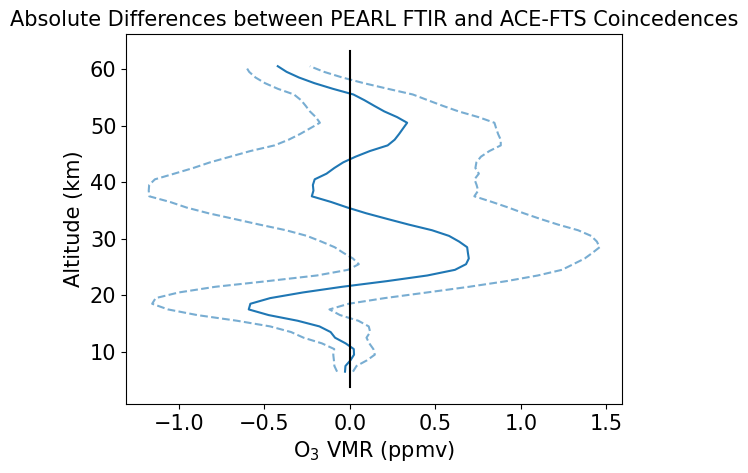

In [ ]:
plt.plot(abs_diffs * 10**6, ALT_GRID)
plt.plot((abs_diffs - abs_std) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot((abs_diffs + abs_std) * 10**6, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot([0, 0], list(plt.ylim()), color = "black")
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between PEARL FTIR and ACE-FTS Coincedences" + " (All time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

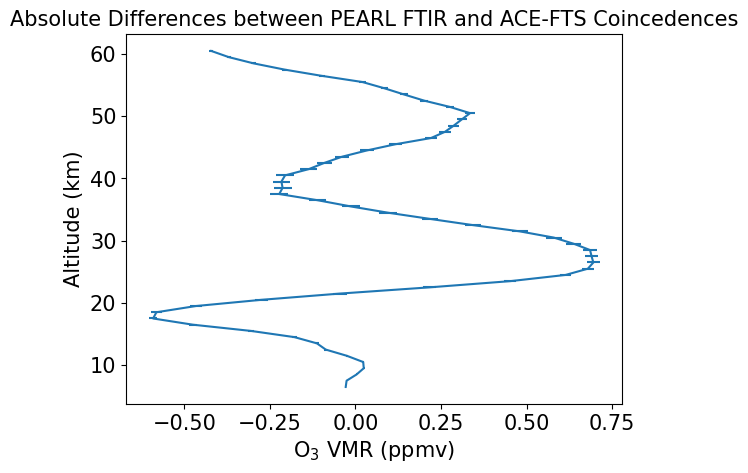

In [ ]:
plt.errorbar(abs_diffs * 10**6, ALT_GRID, xerr = abs_err * 10**6)
plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Absolute Differences between PEARL FTIR and ACE-FTS Coincedences" + " (All time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(err)", bbox_inches="tight")

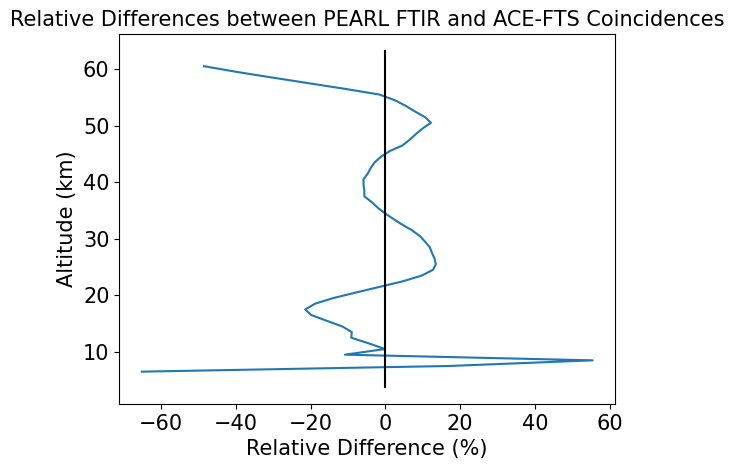

In [ ]:
plt.plot(rel_diffs, ALT_GRID)
plt.plot([0, 0], list(plt.ylim()), color = "black")
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Relative Differences between PEARL FTIR and ACE-FTS Coincidences" + " (All time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

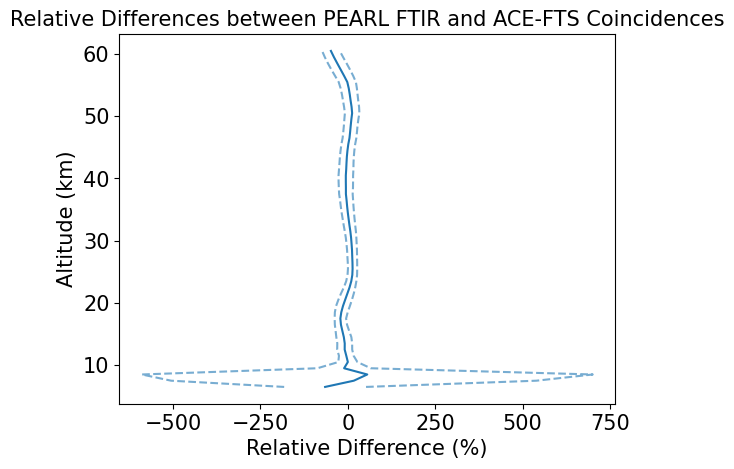

In [ ]:
plt.plot(rel_diffs, ALT_GRID)
plt.plot(rel_diffs - rel_std, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.plot(rel_diffs + rel_std, ALT_GRID, color = "C0", linestyle = "dashed",  alpha = 0.6)
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Relative Differences between PEARL FTIR and ACE-FTS Coincidences" + " (All time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(std)", bbox_inches="tight")

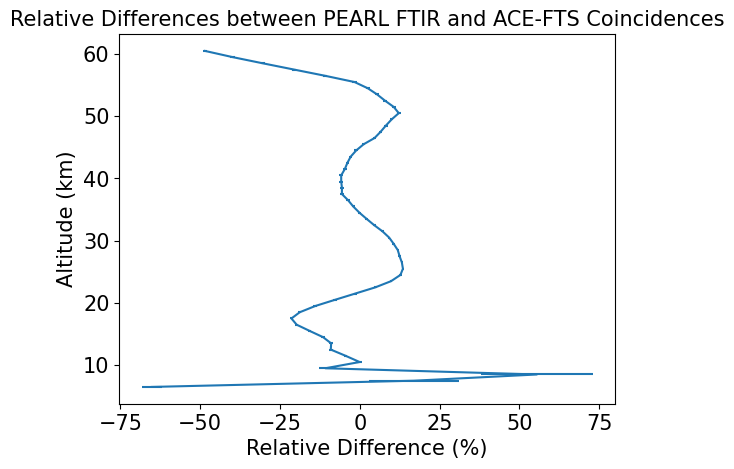

In [ ]:
plt.errorbar(rel_diffs, ALT_GRID, xerr = rel_err)
plt.xlabel("Relative" + " Difference (%)")
plt.ylabel("Altitude (km)")
plt.title("Relative Differences between PEARL FTIR and ACE-FTS Coincidences" + " (All time)", fontdict = {'fontsize': 15})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(err)", bbox_inches="tight")

C:\Users\salla\AppData\Local\Temp\ipykernel_17588\3714386963.py:3: RuntimeWarning: Mean of empty slice
  mean_A = np.nanmean(o3A_coincidences, axis = 0)
C:\Users\salla\AppData\Local\Temp\ipykernel_17588\3714386963.py:4: RuntimeWarning: Mean of empty slice
  mean_P = np.nanmean(o3P_coincidences, axis = 0)


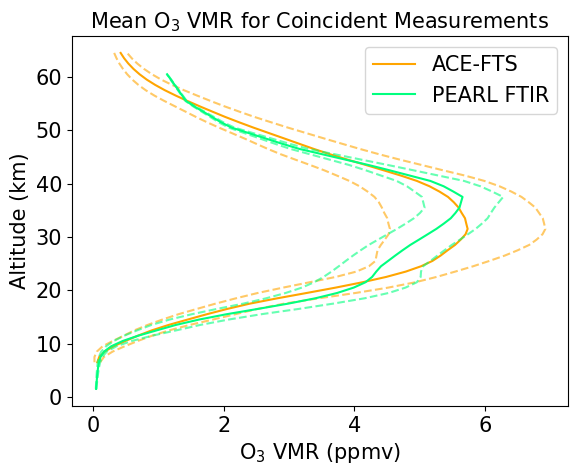

In [ ]:
std_A = np.nanstd(o3A_coincidences, axis = 0)
std_P = np.nanstd(o3P_coincidences, axis = 0)
mean_A = np.nanmean(o3A_coincidences, axis = 0)
mean_P = np.nanmean(o3P_coincidences, axis = 0)

plt.plot(mean_A * 10**6, ALT_GRID, label = "ACE-FTS", color = "orange")
plt.plot((mean_A + std_A) * 10**6, ALT_GRID, color = "orange", linestyle = "dashed",  alpha = 0.6)
plt.plot((mean_A - std_A) * 10**6, ALT_GRID, color = "orange", linestyle = "dashed",  alpha = 0.6)

plt.plot(mean_P * 10**6, ALT_GRID, label = "PEARL FTIR", color = "springgreen")
plt.plot((mean_P - std_P) * 10**6, ALT_GRID, color = "springgreen", linestyle = "dashed",  alpha = 0.6)
plt.plot((mean_P + std_P) * 10**6, ALT_GRID, color = "springgreen", linestyle = "dashed",  alpha = 0.6)

plt.xlabel("O$_3$ VMR (ppmv)")
plt.ylabel("Altitude (km)")
plt.title("Mean O$_3$ VMR for Coincident Measurements" + " (All time)", fontdict = {'fontsize': 15})
plt.legend()

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title + "(ACE-FTS and PEARL FTIR)", bbox_inches="tight")

In [21]:
o3O_std = np.nanstd(o3A_coincidences, axis = 0)[None, :]
o3P_std = np.nanstd(o3P_coincidences, axis = 0)[None, :]
o3O_mean = np.nanmean(o3A_coincidences, axis = 0)[None, :]
o3P_mean = np.nanmean(o3P_coincidences, axis = 0)[None, :]

C:\Users\salla\AppData\Local\Temp\ipykernel_17588\538190962.py:3: RuntimeWarning: Mean of empty slice
  o3O_mean = np.nanmean(o3A_coincidences, axis = 0)[None, :]
C:\Users\salla\AppData\Local\Temp\ipykernel_17588\538190962.py:4: RuntimeWarning: Mean of empty slice
  o3P_mean = np.nanmean(o3P_coincidences, axis = 0)[None, :]


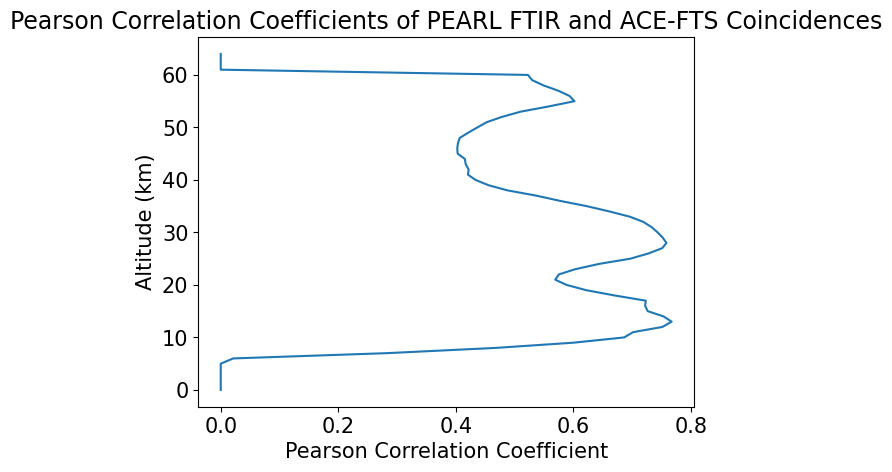

In [ ]:
summing = np.nansum(((o3A_coincidences - o3O_mean) / o3O_std) * ((o3P_coincidences - o3P_mean) / o3P_std), axis = 0) 

plt.plot(summing / (o3A_coincidences.shape[0] - 1), np.arange(len(summing)))
plt.ylabel("Altitude (km)")
plt.xlabel("Pearson Correlation Coefficient")
plt.title("Pearson Correlation Coefficients of PEARL FTIR and ACE-FTS Coincidences" + " (All time)", fontdict = {"fontsize": 17})

fig = plt.gcf()
axes = plt.gca()

title = axes.get_title()
fig.savefig(title, bbox_inches="tight")

In [23]:
# fig = pcm_monthly.fig
# title = fig._suptitle.get_text()
# fig.savefig(title, bbox_inches="tight")

# fig = plt.gcf()
# axes = plt.gca()

# title = axes.get_title()
# fig.savefig(title, bbox_inches="tight")